100%|██████████| 1/1 [00:00<00:00, 185.51it/s]

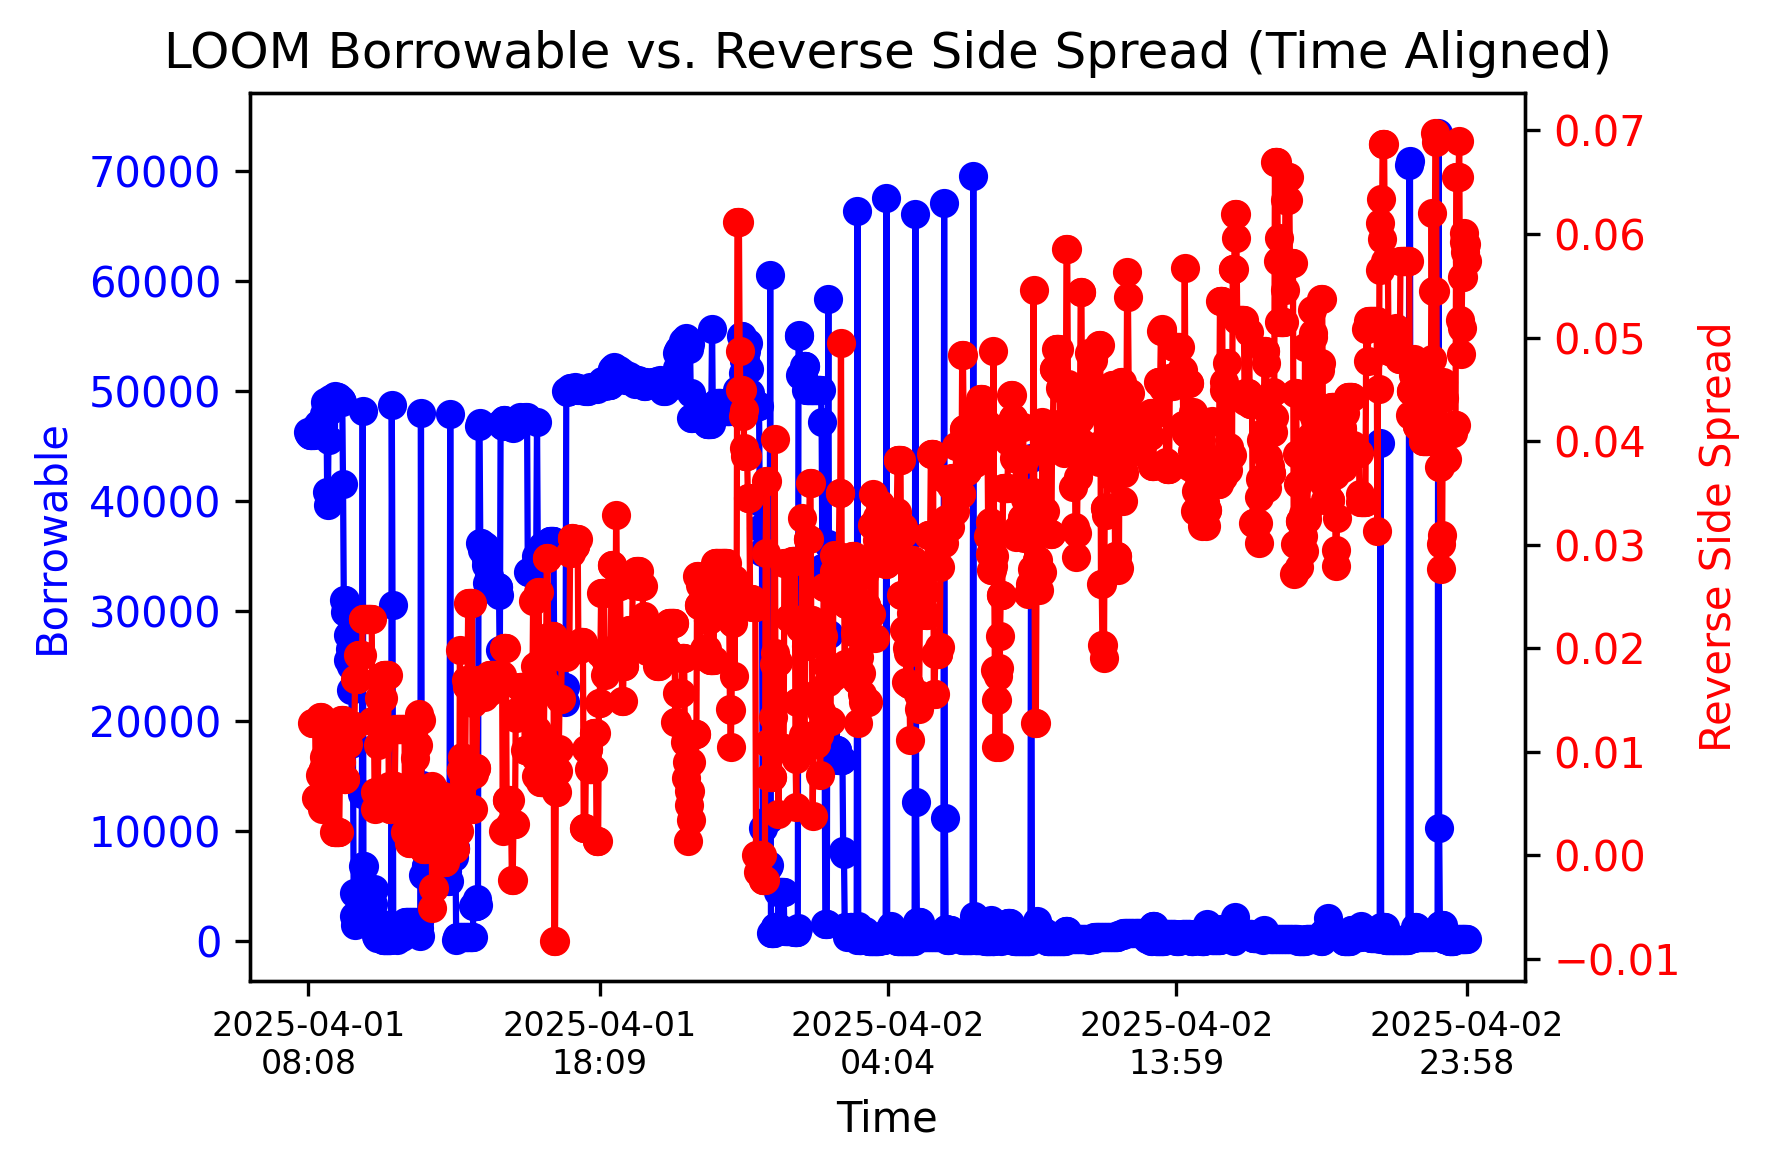

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math
import time
import hashlib
import hmac
import requests
import json
import csv
import os
from tqdm import tqdm
import requests

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

ticker_pool = ['LOOM']  # 可添加多个币种

valid_data = []

for symbol in tqdm(ticker_pool):
    file_name = f"{symbol}_USDT.csv"
    borrow_path = f'/data/market_maker/Gate_io/borrow_data/{file_name}'
    price_path = f'/data/market_maker/Gate_io/price_data/{file_name}'
    
    try:
        df_borrow = pd.read_csv(borrow_path)
        df_price = pd.read_csv(price_path)
    except Exception as e:
        print(f"读取 {file_name} 失败：{e}")
        continue

    if 'Borrowable' not in df_borrow.columns:
        print(f"{file_name} 中未找到 'Borrowable' 列")
        continue

    if not all(col in df_price.columns for col in ['Best_Bid_Spot', 'Best_Ask_Future']):
        print(f"{file_name} 中缺少计算 reverse_side_spread 所需的列")
        continue

    # 计算 reverse_side_spread
    df_price[['Best_Bid_Spot', 'Best_Ask_Future']] = df_price[['Best_Bid_Spot', 'Best_Ask_Future']].ffill()

    df_price['reverse_side_spread'] = (df_price['Best_Bid_Spot'] / df_price['Best_Ask_Future']) - 1

    # 取两个序列的最小长度，并从末尾向前切取，保证时间对齐
    min_len = min(len(df_borrow['Borrowable']), len(df_price['reverse_side_spread']))
    borrow_tail = df_borrow['Borrowable'].iloc[-min_len:]
    spread_tail = df_price['reverse_side_spread'].iloc[-min_len:]

    valid_data.append((symbol, borrow_tail, spread_tail))

# 绘图
if not valid_data:
    print("没有有效的数据进行绘图。")
else:
    for symbol, borrowable_series, spread_series in valid_data:
        min_len = len(borrowable_series)

        # 时间戳作为 x 轴
        time_series = df_borrow['Time'].iloc[-min_len:]
        # （可选）将时间戳转换为 datetime 对象显示更友好
        time_series = pd.to_datetime(time_series, unit='s')

        fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

        # 主 y 轴：Borrowable
        ax1.plot(time_series, borrowable_series, label='Borrowable', color='blue', marker='o', linestyle='-')
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Borrowable", color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # 副 y 轴：Spread
        ax2 = ax1.twinx()
        ax2.plot(time_series, spread_series, label='Reverse Side Spread', color='red', marker='o', linestyle='-')
        ax2.set_ylabel("Reverse Side Spread", color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # 设置 x 轴为 5 个等分时间点
        num_ticks = 5
        tick_indices = np.linspace(0, len(time_series) - 1, num=num_ticks, dtype=int)
        tick_labels = time_series.iloc[tick_indices].dt.strftime('%Y-%m-%d\n%H:%M')

        ax1.set_xticks(time_series.iloc[tick_indices])
        ax1.set_xticklabels(tick_labels, rotation=0, fontsize=8)

        plt.title(f"{symbol} Borrowable vs. Reverse Side Spread (Time Aligned)")
        fig.tight_layout()
        plt.show()


100%|██████████| 1/1 [00:00<00:00, 97.15it/s]


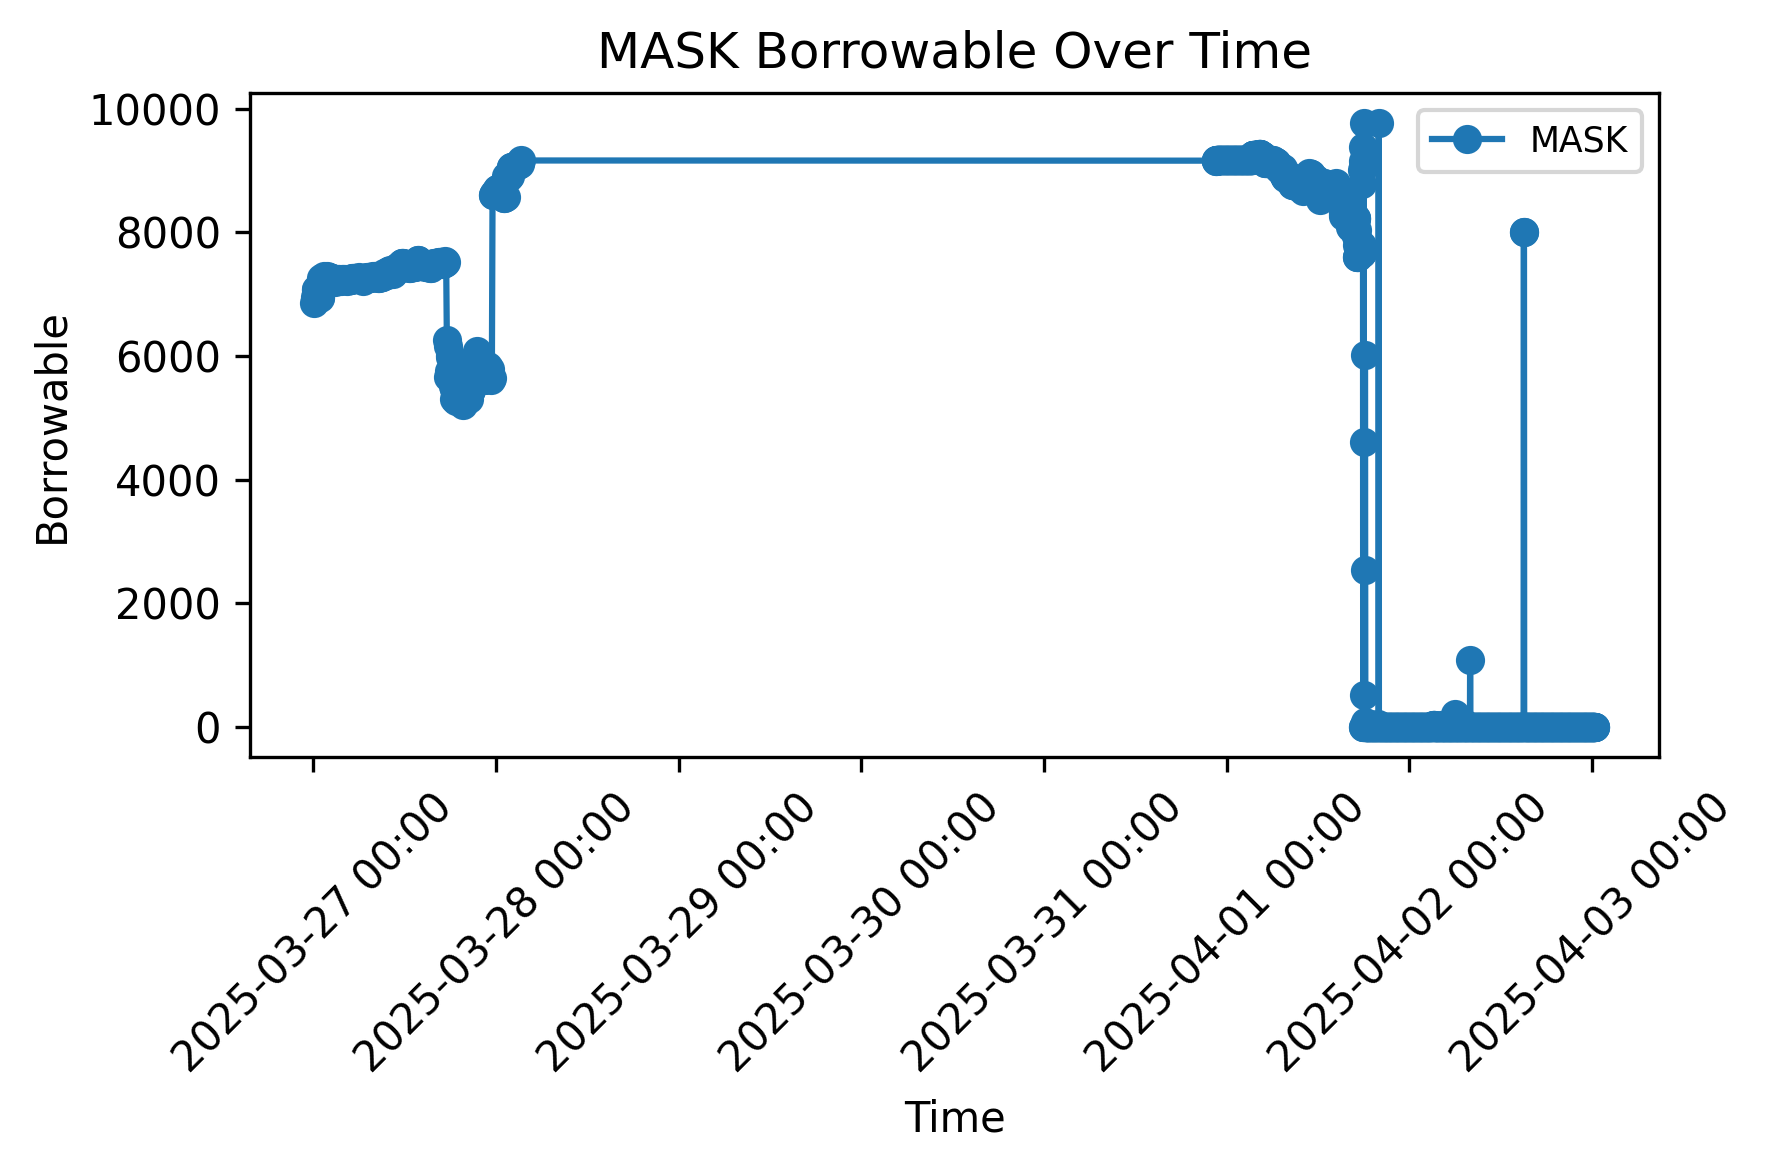

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

ticker_pool = ['MASK']

valid_data = []
for symbol in tqdm(ticker_pool):
    file_name = f"{symbol}_USDT.csv"
    borrow_path = f'/data/market_maker/Gate_io/borrow_data/{file_name}'
    price_path = f'/data/market_maker/Gate_io/price_data/{file_name}'
    
    try:
        df = pd.read_csv(borrow_path)
        df_price = pd.read_csv(price_path)
    except Exception as e:
        print(f"读取 {file_name} 失败：{e}")
        continue
        
    if 'Borrowable' not in df.columns or 'Time' not in df.columns:
        print(f"{file_name} 中未找到 'Borrowable' 或 'Time' 列")
        continue

    # 转换为 datetime 类型
    df['Time'] = pd.to_datetime(df['Time'], unit = "s")
    
    sampled_borrowable = df['Borrowable']
    time_series = df['Time']
    valid_data.append((symbol, time_series, sampled_borrowable))

if not valid_data:
    print("没有有效的数据进行绘图。")
else:
    for symbol, time_series, borrowable_series in valid_data:
        plt.figure(figsize=(6, 4), dpi=300)
        plt.plot(time_series, borrowable_series, label=symbol, linestyle='-', marker='o')
        plt.title(f"{symbol} Borrowable Over Time")
        plt.xlabel("Time")
        plt.ylabel("Borrowable")
        plt.xticks(rotation=45)
        
        # 设置时间显示格式：年-月-日 时:分
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.tight_layout()
        plt.legend(fontsize='small')
        plt.show()


In [11]:
print(df['Time'].head())


0   1970-01-21 04:10:34.076312546
1   1970-01-21 04:10:34.402796080
2   1970-01-21 04:10:34.728080801
3   1970-01-21 04:10:35.051951129
4   1970-01-21 04:10:35.376587173
Name: Time, dtype: datetime64[ns]
